
# Project:Twitter Data Wrangling

## Table of Contents
<ul>
<li><a href="#Intro">Introduction</a></li>
<li><a href="#Gather">Data Gathering</a></li>
<li><a href="#Access">Assessing Data</a></li>
<li><a href="#Clean">Cleaning Data</a></li>
<li><a href="#Analysis">Analyzing, and Visualizing data</a></li>    
</ul>

<a id='Intro'></a>

## Introduction
The dataset that will be wrangled (,analyzed and visualized) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comments about the dogs.

##### The Data
* **Enhanced Twitter Archive:** The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which was used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo).


* **Additional Data via the Twitter API:** Twitter's API was queried to gather this data, retweet count and favorite count are two of the notable column omissions.


* **Image Predictions File:** The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and was downloaded programmatically using the Requests library.

<a id='Gather'></a>

## Data Gathering

In [1]:
#Importing needed libraries
import pandas as pd 
import numpy as np 
import requests 
import json
import tweepy
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re

In [2]:
#Reading the twitter archive csv file of tweets
df = pd.read_csv('../Downloads/twitter-archive-enhanced.csv')
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
#Downloading image prediction file from the udacity url
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

In [4]:
#Reading the image prediction csv file
img_df = pd.read_csv('image-predictions.tsv',sep='\t')
img_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [5]:
# Creating API object to gather Twitter data, ids removed for privacy reasons.
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser = tweepy.parsers.JSONParser(),wait_on_rate_limit=True)

In [6]:
tweet_ids = df['tweet_id']

In [7]:
#Download Tweepy status object based on Tweet ID and store in list
success = []
# Tweets that can't be found would be saved in the list below:
failures = []
for tweet_id in tweet_ids:
    try:
        success.append(api.get_status(tweet_id, tweet_mode='extended'))
    except Exception as e:
            failures.append(tweet_id)

Rate limit reached. Sleeping for: 342
Rate limit reached. Sleeping for: 351


In [8]:
print("success" ,len(success))
print("failures" , len(failures))

success 2327
failures 29


In [9]:
#Storing the json data in txt file
with open('tweet_json.txt', 'w') as file:
    json.dumps(success, indent=4)

In [10]:
#opening json file 
df_list = []

with open('tweet_json.txt') as file:
    for line in file:
        df_list.append(json.loads(line))

In [11]:
#reading json file data
tweet_data = pd.DataFrame(success, columns = ['id' , 'retweet_count' , 'favorite_count'])
tweet_data

,id,retweet_count,favorite_count
0,892420643555336193,6970,33697
1,892177421306343426,5272,29228
2,891815181378084864,3464,21976
3,891689557279858688,7191,36795
4,891327558926688256,7718,35185
...,...,...,...
2322,666049248165822465,36,88
2323,666044226329800704,115,246
2324,666033412701032449,36,100
2325,666029285002620928,39,112


In [12]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2327 non-null   int64
 1   retweet_count   2327 non-null   int64
 2   favorite_count  2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


<a id='Access'></a>
## Assessing Data 

#### Enhanced Twitter Archive(df)

##### *Visual Assessement*

In [13]:
df.head(51)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
df.sample(51)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2142,669972011175813120,NaN,NaN,2015-11-26 20:12:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we see really big dog cuddling smaller do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669972011...,10,10,None,None,None,None,None
1293,708026248782585858,NaN,NaN,2016-03-10 20:26:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Everybody stop what you're doing and watch thi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/708026248...,13,10,None,None,None,None,None
267,841680585030541313,NaN,NaN,2017-03-14 16:01:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. She's a dragon slayer. Feared b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/841680585...,12,10,Penny,None,None,None,None
1720,680145970311643136,NaN,NaN,2015-12-24 22:00:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Kawhi. He was doing fine until hi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680145970...,10,10,Kawhi,None,None,pupper,None
930,754449512966619136,NaN,NaN,2016-07-16 22:55:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dex. He can see into your past and fut...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754449512...,11,10,Dex,None,None,None,None
594,798705661114773508,NaN,NaN,2016-11-16 01:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Baloo. He's expecting a fa...,7.406770e+17,4.196984e+09,2016-06-08 22:48:46 +0000,https://twitter.com/dog_rates/status/740676976...,11,10,Baloo,None,None,pupper,None
2275,667453023279554560,NaN,NaN,2015-11-19 21:22:56 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet Cupcake. I would do unspeakable things fo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667453023...,11,10,Cupcake,None,None,None,None
2045,671528761649688577,NaN,NaN,2015-12-01 03:18:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He's in the middle of a serious conv...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671528761...,10,10,Jax,None,None,None,None
1044,743609206067040256,NaN,NaN,2016-06-17 01:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Stark. He just had his first ice cream co...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743609206...,10,10,Stark,None,None,None,None
1258,710283270106132480,NaN,NaN,2016-03-17 01:55:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gunner. He's a Figamus Newton. King of...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710283270...,11,10,Gunner,None,None,None,None


##### *Programmatic Assessement*

In [16]:
df.tweet_id.duplicated().sum()

0

In [17]:
df.expanded_urls.duplicated().sum()

137

In [18]:
df.name.duplicated().sum()

1399

In [19]:
df.name.value_counts()

None            745
a                55
Charlie          12
Lucy             11
Oliver           11
               ... 
Pippin            1
Mack              1
Rolf              1
unacceptable      1
Teddy             1
Name: name, Length: 957, dtype: int64

In [20]:
df[df['name'] != 'None'].name.count()

1611

In [21]:
df[df['name'] == 'None'].name.count()

745

In [22]:
df[df['name'] == 'a'].name.count()

55

In [23]:
df[df['name'] == 'an'].name.count()

7

In [24]:
df[df['name'] == 'the'].name.count()

8

In [25]:
df[df['name'] == 'very'].name.count()

5

In [26]:
df[df['name'] == 'not'].name.count()

2

In [27]:
df.name.value_counts()

None            745
a                55
Charlie          12
Lucy             11
Oliver           11
               ... 
Pippin            1
Mack              1
Rolf              1
unacceptable      1
Teddy             1
Name: name, Length: 957, dtype: int64

In [28]:
df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [29]:
#Dog stages are not merged correctly
ds = df.loc[(df[['doggo', 'floofer', 'pupper', 'puppo']] != 'None').
       sum(axis=1) > 1]
ds

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Like father (doggo), like son (...",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo,None,pupper,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is just downright precious...,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,https://twitter.com/dog_rates/status/741067306...,12,10,just,doggo,None,pupper,None


In [30]:
len(ds)

14

In [31]:
print(len(df[df['retweeted_status_id'].notnull()]))
print(len(df[df['retweeted_status_timestamp'].notnull()]))
print(len(df[df['retweeted_status_user_id'].notnull()]))

181
181
181


In [32]:
len(df[df.retweeted_status_id.notnull()])
len(df[df.retweeted_status_timestamp.notnull()])

181

In [33]:
df[df.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

C:\Users\maxim\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,text,rating_numerator
45,This is Bella. She hopes her smile made you sm...,5
340,"RT @dog_rates: This is Logan, the Chow who liv...",75
695,"This is Logan, the Chow who lived. He solemnly...",75
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27
1689,I've been told there's a slight possibility he...,5
1712,Here we have uncovered an entire battalion of ...,26


#### Image Predictions File(img_df)

##### *Visual Assessement*

In [34]:
img_df.head(51)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [35]:
img_df.sample(51)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1181,738184450748633089,https://pbs.twimg.com/media/Cj6O1G9UYAAIU-1.jpg,1,Bedlington_terrier,0.289471,True,standard_poodle,0.173685,True,Great_Pyrenees,0.157081,True
757,688547210804498433,https://pbs.twimg.com/media/CY42CFWW8AACOwt.jpg,1,papillon,0.531279,True,Blenheim_spaniel,0.214197,True,Border_collie,0.053840,True
1087,718939241951195136,https://pbs.twimg.com/media/CfovbK4WIAAkTn3.jpg,1,Pembroke,0.766327,True,Cardigan,0.222126,True,toilet_tissue,0.006757,False
760,688828561667567616,https://pbs.twimg.com/media/CY816snW8AYltrQ.jpg,1,Cardigan,0.614231,True,skunk,0.139392,False,toilet_tissue,0.031158,False
485,675489971617296384,https://pbs.twimg.com/media/CV_SimUWoAAvJSY.jpg,1,West_Highland_white_terrier,0.139613,True,seat_belt,0.118647,False,Old_English_sheepdog,0.093952,True
986,707693576495472641,https://pbs.twimg.com/media/CdI7jDnW0AA2dtO.jpg,1,bathtub,0.499525,False,tub,0.488014,False,washbasin,0.009298,False
1573,795400264262053889,https://pbs.twimg.com/media/CwnUUGTWIAE8sFR.jpg,2,golden_retriever,0.925494,True,Labrador_retriever,0.059241,True,tennis_ball,0.004495,False
987,707741517457260545,https://pbs.twimg.com/media/CdJnJ1dUEAARNcf.jpg,1,whippet,0.738371,True,Italian_greyhound,0.191789,True,American_Staffordshire_terrier,0.020126,True
1808,832636094638288896,https://pbs.twimg.com/media/C44eG7oUMAAA4Ss.jpg,1,Eskimo_dog,0.525032,True,Siberian_husky,0.252238,True,malamute,0.216839,True
2016,879862464715927552,https://pbs.twimg.com/media/DDXmPrbWAAEKMvy.jpg,3,basset,0.813507,True,beagle,0.146654,True,cocker_spaniel,0.009485,True


##### *Programmatic Assessement*

In [36]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [37]:
img_df.tweet_id.duplicated().sum()

0

#### Additional Data via the Twitter API (tweet_data)

##### *Visual Assessement*

In [38]:
tweet_data.head(51)

,id,retweet_count,favorite_count
0,892420643555336193,6970,33697
1,892177421306343426,5272,29228
2,891815181378084864,3464,21976
3,891689557279858688,7191,36795
4,891327558926688256,7718,35185
5,891087950875897856,2586,17752
6,890971913173991426,1647,10335
7,890729181411237888,15682,56675
8,890609185150312448,3604,24429
9,890240255349198849,6068,27851


In [39]:
tweet_data.sample(51)

,id,retweet_count,favorite_count
715,781163403222056960,2572,9241
1436,694356675654983680,250,1386
1505,689999384604450816,328,1304
315,832998151111966721,2007,12403
1178,715758151270801409,1282,3409
1563,686606069955735556,490,1748
387,823939628516474880,2523,10036
1463,692894228850999298,713,2079
985,747219827526344708,1433,4875
2161,668960084974809088,209,618


##### *Programmatic Assessement*

In [40]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2327 non-null   int64
 1   retweet_count   2327 non-null   int64
 2   favorite_count  2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [41]:
tweet_data.id.duplicated().sum()

0

## Assessing Observations


### Quality 

#### *Enhanced Twitter Archive(df)*
- From the assesing data objectives it was stated that only original data would be needed, hence, some columns and rows won't be needed. example `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`
- `timestamp` is object dtype instead of datetime
- `tweet_id` is int dtype instead of object or string
- Nulls represented as 'None' in the `name` column
- Duplicated and very unsual dog names like 'a', 'an','the','very' and 'not'
- Unnecessary html tags in `source` column in place of utility name.
- Some rows in `rating_numerator` were not correctly extracted
- `rating_numerator` and `rating_denominator` is int dtype instead of object or float


#### *Image Predictions File(img_df)*
- `tweet_id` is int dtype instead of object or string

#### *Additional Data via the Twitter API(tweet_data)*
- Column named `id` instead of `tweet_id`
- `id` as int type instaed of string type


### Tidiness  
- All tables should be part of one dataset
- Column `doggo`, `floofer`, `pupper`, and `puppo` in the df could be in one column not 4

<a id='Clean'></a>
## Cleaning

In [42]:
# Making copies of original pieces of data
df_clean = df.copy()
img_df_clean = img_df.copy()
tweet_data_clean = tweet_data.copy()

## Quality

### *twitter_archive*
1. Remove rows in `rating_numerator` that were not correctly extracted
2. Change `rating_numerator` and `rating_denominator` from int dtype to object or float dtype
3. Remove rows with retweeted values.
4. Remove `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` column and retweeted rows.
5. Change `timestamp` from object dtype to datetime dtype
6. Change `tweet_id` from int dtype to object or string dtype
7. Change Nulls represented as None in the `name` column to NaN 
8. Change rows with very unusual dog names like 'a' and 'an' to NaN
9. Removing the anchor link and retaining only the text for `source` column

In [43]:
df_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


###### Define
1. Remove rows in `rating_numerator` were not correctly extracted
2. Change `rating_numerator` and `rating_denominator` from int dtype to object or float dtype

#### Code

In [44]:
df_clean['rating_numerator'] =  df_clean['rating_numerator'].astype(str)

In [45]:
dt1 = df_clean[df_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]
dt1

C:\Users\maxim\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,text,rating_numerator
45,This is Bella. She hopes her smile made you sm...,5
340,"RT @dog_rates: This is Logan, the Chow who liv...",75
695,"This is Logan, the Chow who lived. He solemnly...",75
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27
1689,I've been told there's a slight possibility he...,5
1712,Here we have uncovered an entire battalion of ...,26


In [46]:
dt1.rating_numerator = df_clean['text'].str.extract(r"(\d+\.\d*\/\d+)")

In [47]:
dt2 = dt1.rating_numerator.str[:-3]
dt2

45       13.5
340      9.75
695      9.75
763     11.27
1689      9.5
1712    11.26
Name: rating_numerator, dtype: object

In [48]:
df_clean.loc[[45, 340, 695, 763, 1689, 1712],['rating_numerator']]  = dt2

In [49]:
df_clean.rating_numerator = df_clean.rating_numerator.astype(float)
df_clean.rating_denominator = df_clean.rating_denominator.astype(float)

##### Test

In [50]:
df_clean[df_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

C:\Users\maxim\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,text,rating_numerator
45,This is Bella. She hopes her smile made you sm...,13.50
340,"RT @dog_rates: This is Logan, the Chow who liv...",9.75
695,"This is Logan, the Chow who lived. He solemnly...",9.75
763,This is Sophie. She's a Jubilant Bush Pupper. ...,11.27
1689,I've been told there's a slight possibility he...,9.50
1712,Here we have uncovered an entire battalion of ...,11.26


In [51]:
df_clean.loc[[ 45, 340, 695, 763, 1689, 1712]]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,13.50,10.0,Bella,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,11.27,10.0,Sophie,None,None,pupper,None
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've been told there's a slight possibility he...,NaN,NaN,NaN,NaN,9.50,10.0,None,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,11.26,10.0,None,None,None,None,None


In [52]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   float64
 11  rating_denominator          2356 non-null   float64
 12  name                        2356 non-null   object 
 13  doggo                       2356 

###### Define
3. Remove rows with retweeted values.

###### Code

In [53]:
df_clean.drop(df_clean.index[df_clean['retweeted_status_id'].notnull()], inplace = True)
df_clean.drop(df_clean.index[df_clean['retweeted_status_timestamp'].notnull()], inplace = True)
df_clean.drop(df_clean.index[df_clean['retweeted_status_user_id'].notnull()], inplace = True)

###### Test

In [54]:
print(len(df_clean[df_clean['retweeted_status_id'].notnull()]))
print(len(df_clean[df_clean['retweeted_status_timestamp'].notnull()]))
print(len(df_clean[df_clean['retweeted_status_user_id'].notnull()]))

0
0
0


###### Define
4. Remove `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`.

###### Code

In [55]:
df_clean.drop(columns = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], 
                      inplace = True)

##### Test

In [56]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   float64
 8   rating_denominator     2175 non-null   float64
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
dtypes: float64(4), int64(1), object(9)
memory usage: 334.9+ 

###### Define
5. Change `timestamp` from object dtype to datetime dtype
6. Change `tweet_id` from int dtype to object or string dtype

###### Code

In [57]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean['tweet_id'] =  df_clean['tweet_id'].astype(str)

##### Test

In [58]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2175 non-null   float64            
 8   rating_denominator     2175 non-null   float64            
 9   name                   2175 non-null   object             
 10  doggo                  2175 non-null   object             
 11  floofer                2175 non-null   object           

###### Define
7. Change Nulls represented as None in the `name` column to NaN 
8. Change rows with very unsual dog names like 'a' and 'an' to NaN

###### Code

In [59]:
df_clean.name.replace("None", value = np.nan, inplace=True )
df_clean.name.replace("a", value = np.nan, inplace=True )
df_clean.name.replace("an", value = np.nan, inplace=True )
df_clean.name.replace("the", value = np.nan, inplace=True )
df_clean.name.replace("very", value = np.nan, inplace=True )
df_clean.name.replace("not", value = np.nan, inplace=True )
df_clean.doggo.replace("None", value = np.nan, inplace = True )
df_clean.floofer.replace("None", value = np.nan, inplace = True )
df_clean.pupper.replace("None", value = np.nan,inplace = True )
df_clean.puppo.replace("None", value = np.nan,inplace = True )

##### Test

In [60]:
df_clean.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1855,675531475945709568,NaN,NaN,2015-12-12 04:23:49+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Ellie AKA Queen Slayer of the Orbs. Ve...,https://twitter.com/dog_rates/status/675531475...,10.00,10.0,Ellie,NaN,NaN,NaN,NaN
1330,705786532653883392,7.032559e+17,4.196984e+09,2016-03-04 16:06:36+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Seriously, add us 🐶 11/10 for sad wet pupper h...",https://twitter.com/dog_rates/status/705786532...,11.00,10.0,NaN,NaN,NaN,pupper,NaN
975,750041628174217216,NaN,NaN,2016-07-04 19:00:33+00:00,"<a href=""https://about.twitter.com/products/tw...",This is Beau. He's trying to keep his daddy fr...,https://twitter.com/dog_rates/status/750041628...,13.00,10.0,Beau,NaN,NaN,NaN,NaN
1326,706153300320784384,NaN,NaN,2016-03-05 16:24:01+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Layla. She's giving you a standing ova...,https://vine.co/v/iXidJXBJ3P9,13.00,10.0,Layla,NaN,NaN,NaN,NaN
409,823333489516937216,8.233264e+17,1.582854e+09,2017-01-23 00:56:15+00:00,"<a href=""http://twitter.com/download/iphone"" r...",@HistoryInPics 13/10,NaN,13.00,10.0,NaN,NaN,NaN,NaN,NaN
2074,670842764863651840,NaN,NaN,2015-11-29 05:52:33+00:00,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,https://twitter.com/dog_rates/status/670842764...,420.00,10.0,NaN,NaN,NaN,NaN,NaN
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,14.00,10.0,NaN,NaN,NaN,NaN,NaN
1067,740676976021798912,NaN,NaN,2016-06-08 22:48:46+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Meet Baloo. He's expecting a fast ground ball,...",https://twitter.com/dog_rates/status/740676976...,11.00,10.0,Baloo,NaN,NaN,pupper,NaN
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10.0,Logan,NaN,NaN,NaN,NaN
867,761976711479193600,NaN,NaN,2016-08-06 17:26:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Shelby. She finds stuff to put on her ...,https://twitter.com/dog_rates/status/761976711...,12.00,10.0,Shelby,NaN,NaN,NaN,NaN


In [61]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2175 non-null   float64            
 8   rating_denominator     2175 non-null   float64            
 9   name                   1420 non-null   object             
 10  doggo                  87 non-null     object             
 11  floofer                10 non-null     object           

In [62]:
df_clean.isnull().sum()

tweet_id                    0
in_reply_to_status_id    2097
in_reply_to_user_id      2097
timestamp                   0
source                      0
text                        0
expanded_urls              58
rating_numerator            0
rating_denominator          0
name                      755
doggo                    2088
floofer                  2165
pupper                   1941
puppo                    2150
dtype: int64

In [63]:
df_clean.name.value_counts()

Lucy            11
Charlie         11
Cooper          10
Oliver          10
Tucker           9
                ..
Chevy            1
Alexanderson     1
Ken              1
Meatball         1
Teddy            1
Name: name, Length: 950, dtype: int64

###### Define
9. Removing the anchor link and retaining only the text for `source` column

###### Code

In [64]:
df_clean['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2042
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [65]:
df_clean['source'] = df_clean['source'].str.extract('^<a.+>(.+)</a>$')

##### Test

In [66]:
df_clean['source'].value_counts()

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

### *image_prediction*
1. Change `tweet_id` from int dtype to object or string

###### Define
1. Change `tweet_id` from int dtype to object or string

###### Code

In [67]:
img_df_clean['tweet_id'] =  img_df_clean['tweet_id'].astype(str)

##### Test

In [68]:
img_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### *tweet_json*
1. Change column name from `id` to `tweet_id`
2. Change column `id` (now `tweet_id`) from int dtype to string dtype

###### Define
1. Change column name from `id` to `tweet_id`

###### Code

In [69]:
tweet_data_clean.rename(columns = {'id':'tweet_id'}, inplace = True)

##### Test

In [70]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2327 non-null   int64
 1   retweet_count   2327 non-null   int64
 2   favorite_count  2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


###### Define
2. Change `tweet_id` from int dtype to string dtype

###### Code

In [71]:
tweet_data_clean['tweet_id'] =  tweet_data_clean['tweet_id'].astype(str)

##### Test

In [72]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2327 non-null   object
 1   retweet_count   2327 non-null   int64 
 2   favorite_count  2327 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


### Tidiness  
1. Join column `doggo`, `floofer`, `pupper`, and `puppo` in df into one column not 4
2. Join all tables into of one dataset

###### Define
1. Join column `doggo`, `floofer`, `pupper`, and `puppo` in df into one column not 4

###### Code

In [73]:
# merge different dog types into a column dog_class
df_clean['dog_stage'] = df_clean[['puppo', 'pupper', 'floofer', 'doggo']].apply(
    lambda x: ','.join(x.astype(str)),axis=1)
df_clean['dog_stage'] = df_clean['dog_stage'].str.replace(r'(,nan)', repl='')
df_clean['dog_stage'] = df_clean['dog_stage'].str.replace(r'(nan,)', repl='')
df_clean['dog_stage'] = df_clean['dog_stage'].str.replace(r'(,nan, )', repl='')
df_clean.drop(['puppo','pupper','floofer','doggo'], axis=1, inplace=True)

##### Test

In [74]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   object             
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2175 non-null   float64            
 8   rating_denominator     2175 non-null   float64            
 9   name                   1420 non-null   object             
 10  dog_stage              2175 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(4), object(6)
memory 

In [75]:
df_dog = df_clean[df_clean['dog_stage'] != 'nan']

In [76]:
df_dog.dog_stage.value_counts()

pupper           224
doggo             75
puppo             24
pupper,doggo      10
floofer            9
puppo,doggo        1
floofer,doggo      1
Name: dog_stage, dtype: int64

In [77]:
df_clean.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
2131,670086499208155136,NaN,NaN,2015-11-27 03:47:25+00:00,Twitter for iPhone,"""Hi yes this is dog. I can't help with that s-...",https://twitter.com/dog_rates/status/670086499...,10.0,10.0,NaN,nan
371,828408677031882754,NaN,NaN,2017-02-06 01:03:14+00:00,Twitter for iPhone,This is Bear. He went outside to play in the s...,https://twitter.com/dog_rates/status/828408677...,12.0,10.0,Bear,nan
1050,743210557239623680,NaN,NaN,2016-06-15 22:36:19+00:00,Twitter for iPhone,"Meet Kayla, an underground poker legend. Playe...",https://twitter.com/dog_rates/status/743210557...,10.0,10.0,Kayla,nan
1904,674632714662858753,NaN,NaN,2015-12-09 16:52:27+00:00,Twitter for iPhone,Rare submerged pup here. Holds breath for a lo...,https://twitter.com/dog_rates/status/674632714...,5.0,10.0,NaN,nan
1247,711652651650457602,NaN,NaN,2016-03-20 20:36:28+00:00,Twitter for iPhone,This is Gary. He just wanted to say hi. 9/10 v...,https://twitter.com/dog_rates/status/711652651...,9.0,10.0,Gary,nan
1866,675349384339542016,6.749998e+17,4.196984e+09,2015-12-11 16:20:15+00:00,Twitter for iPhone,Yea I lied. Here's more. All 13/10 https://t.c...,https://twitter.com/dog_rates/status/675349384...,13.0,10.0,NaN,nan
2085,670804601705242624,NaN,NaN,2015-11-29 03:20:54+00:00,Twitter for iPhone,Meet Mason. He's a total frat boy. Pretends to...,https://twitter.com/dog_rates/status/670804601...,10.0,10.0,Mason,nan
940,753026973505581056,NaN,NaN,2016-07-13 00:43:15+00:00,Twitter for iPhone,Say hello to Tayzie. She's a Barbadian Bugaboo...,https://twitter.com/dog_rates/status/753026973...,10.0,10.0,Tayzie,nan
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08+00:00,Twitter for iPhone,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8.0,10.0,NaN,nan
378,827933404142436356,NaN,NaN,2017-02-04 17:34:40+00:00,Twitter for iPhone,This is Kona. Yesterday she stopped by the dep...,https://twitter.com/dog_rates/status/827933404...,12.0,10.0,Kona,pupper


###### Define
2. Join all tables into of one dataset

###### code

In [78]:
merged_df = df_clean.merge(img_df_clean,left_on='tweet_id',right_on='tweet_id',how='inner')
merged_df = merged_df.merge(tweet_data_clean,left_on='tweet_id',right_on='tweet_id',how='inner')

###### Test

In [79]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1986 non-null   object             
 1   in_reply_to_status_id  23 non-null     float64            
 2   in_reply_to_user_id    23 non-null     float64            
 3   timestamp              1986 non-null   datetime64[ns, UTC]
 4   source                 1986 non-null   object             
 5   text                   1986 non-null   object             
 6   expanded_urls          1986 non-null   object             
 7   rating_numerator       1986 non-null   float64            
 8   rating_denominator     1986 non-null   float64            
 9   name                   1368 non-null   object             
 10  dog_stage              1986 non-null   object             
 11  jpg_url                1986 non-null   object           

In [80]:
merged_df.sample(51)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
461,793210959003287553,NaN,NaN,2016-10-31 22:00:04+00:00,Twitter for iPhone,This is Maude. She's the h*ckin happiest wasp ...,https://twitter.com/dog_rates/status/793210959...,10.0,10.0,Maude,...,0.874431,False,French_bulldog,0.018759,True,Boston_bull,0.015134,True,2600,8446
485,789530877013393408,NaN,NaN,2016-10-21 18:16:44+00:00,Twitter for iPhone,This is Rizzy. She smiles a lot. 12/10 contagi...,https://twitter.com/dog_rates/status/789530877...,12.0,10.0,Rizzy,...,0.363272,True,kelpie,0.197021,True,Norwegian_elkhound,0.151024,True,3144,11053
86,871879754684805121,NaN,NaN,2017-06-06 00:01:46+00:00,Twitter for iPhone,Say hello to Lassie. She's celebrating #PrideM...,https://twitter.com/dog_rates/status/871879754...,13.0,10.0,Lassie,...,0.969171,True,collie,0.018261,True,Pomeranian,0.008515,True,9210,32976
1113,698195409219559425,NaN,NaN,2016-02-12 17:22:12+00:00,Twitter for iPhone,Meet Beau &amp; Wilbur. Wilbur stole Beau's be...,https://twitter.com/dog_rates/status/698195409...,9.0,10.0,Beau,...,0.643690,True,American_Staffordshire_terrier,0.102684,True,dalmatian,0.050008,True,5438,15490
475,791312159183634433,NaN,NaN,2016-10-26 16:14:55+00:00,Twitter for iPhone,This is Mabel. She's super h*ckin smol. Portab...,https://twitter.com/dog_rates/status/791312159...,12.0,10.0,Mabel,...,0.892925,True,toy_terrier,0.095524,True,Doberman,0.003544,True,2356,8297
191,844979544864018432,7.590995e+17,4.196984e+09,2017-03-23 18:29:57+00:00,Twitter for iPhone,PUPDATE: I'm proud to announce that Toby is 23...,https://twitter.com/dog_rates/status/844979544...,13.0,10.0,NaN,...,0.999281,False,racket,0.000370,False,Shetland_sheepdog,0.000132,True,2306,12650
196,843604394117681152,NaN,NaN,2017-03-19 23:25:35+00:00,Twitter for iPhone,This is Hank. He's been outside for 3 minutes ...,https://twitter.com/dog_rates/status/843604394...,11.0,10.0,Hank,...,0.430583,True,golden_retriever,0.263581,True,Great_Pyrenees,0.179385,True,2475,15665
1112,698262614669991936,NaN,NaN,2016-02-12 21:49:15+00:00,Twitter for iPhone,This is Franklin. He's a yoga master. Trying t...,https://twitter.com/dog_rates/status/698262614...,11.0,10.0,Franklin,...,0.107948,True,basset,0.075230,True,Staffordshire_bullterrier,0.069436,True,1793,4391
1261,686377065986265092,NaN,NaN,2016-01-11 02:40:19+00:00,Twitter for iPhone,Meet Birf. He thinks he's gone blind. 10/10 ve...,https://twitter.com/dog_rates/status/686377065...,10.0,10.0,Birf,...,0.830816,True,Leonberg,0.076325,True,bloodhound,0.037449,True,514,2044
1314,683391852557561860,NaN,NaN,2016-01-02 20:58:09+00:00,Twitter for iPhone,"Say hello to Jack (pronounced ""Kevin""). He's a...",https://twitter.com/dog_rates/status/683391852...,11.0,10.0,Jack,...,0.992833,True,Boston_bull,0.004749,True,pug,0.001392,True,2172,7034


##### Define
- Remove column `in_reply_to_status_id`  and  `in_reply_to_user_id`. Both only have 23 non-null values

##### code

In [81]:
merged_df.drop(columns = ['in_reply_to_status_id', 'in_reply_to_user_id'], 
                      inplace = True)

In [82]:
df53 =merged_df[merged_df['dog_stage'] != 'None']

In [83]:
df53.dog_stage.value_counts()

nan              1681
pupper            203
doggo              62
puppo              22
pupper,doggo        9
floofer             7
floofer,doggo       1
puppo,doggo         1
Name: dog_stage, dtype: int64

In [85]:
df54 =merged_df[merged_df['dog_stage'] != 'nan']

In [86]:
df54.dog_stage.value_counts()

pupper           203
doggo             62
puppo             22
pupper,doggo       9
floofer            7
puppo,doggo        1
floofer,doggo      1
Name: dog_stage, dtype: int64

##### Test

In [87]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1986 non-null   object             
 1   timestamp           1986 non-null   datetime64[ns, UTC]
 2   source              1986 non-null   object             
 3   text                1986 non-null   object             
 4   expanded_urls       1986 non-null   object             
 5   rating_numerator    1986 non-null   float64            
 6   rating_denominator  1986 non-null   float64            
 7   name                1368 non-null   object             
 8   dog_stage           1986 non-null   object             
 9   jpg_url             1986 non-null   object             
 10  img_num             1986 non-null   int64              
 11  p1                  1986 non-null   object             
 12  p1_conf             1986 non-null 

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [88]:
merged_df.to_csv("twitter_archive_master.csv")

In [89]:
df_merged_data = pd.read_csv ( "twitter_archive_master.csv")

<a id='Analysis'></a>
# Analysis and Visualization

In [90]:
#making a copy of the merged data
df_merged_data = merged_df.copy()

In [91]:
df_merged_data.head(51)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,nan,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,6970,33697
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,nan,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5272,29228
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,nan,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3464,21976
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,nan,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7191,36795
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,nan,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,7718,35185
5,891087950875897856,2017-07-29 00:08:17+00:00,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13.0,10.0,NaN,nan,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,...,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,2586,17752
6,890971913173991426,2017-07-28 16:27:12+00:00,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10.0,Jax,nan,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,...,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,1647,10335
7,890729181411237888,2017-07-28 00:22:40+00:00,Twitter for iPhone,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13.0,10.0,NaN,nan,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,...,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,15682,56675
8,890609185150312448,2017-07-27 16:25:51+00:00,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13.0,10.0,Zoey,nan,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,...,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,3604,24429
9,890240255349198849,2017-07-26 15:59:51+00:00,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14.0,10.0,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,...,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,6068,27851


## Top Tweet Sources

In [92]:
df_merged_data.source.value_counts()

Twitter for iPhone    1948
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

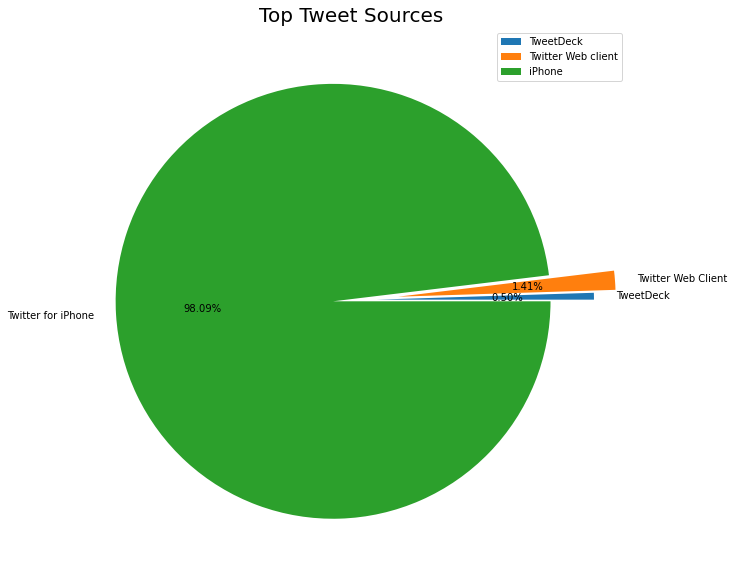

In [93]:
tweet_sources = df_merged_data.groupby('source').count()[['tweet_id']]
tweet_sources.rename(columns={'tweet_id': 'source_count'}, inplace=True)
tweet_sources['source_percentage'] = tweet_sources.source_count / tweet_sources.source_count.sum() * 100
tweet_sources['source_percentage'].plot.pie(figsize=(10,10), autopct='%1.2f%%', explode=[0.1,0.2,0.1])
plt.title("Top Tweet Sources ", {'fontsize': 20})
plt.legend(["TweetDeck", "Twitter Web client", "iPhone"])
plt.ylabel('');

## Insights
- From the pie chart, most tweets came from iPhone and the least from TweetDeck

## Dog Stage ratio

In [94]:
df_dog_s = df_merged_data[df_merged_data['dog_stage'] != 'nan']
df_dog_s.dog_stage.value_counts()

pupper           203
doggo             62
puppo             22
pupper,doggo       9
floofer            7
puppo,doggo        1
floofer,doggo      1
Name: dog_stage, dtype: int64

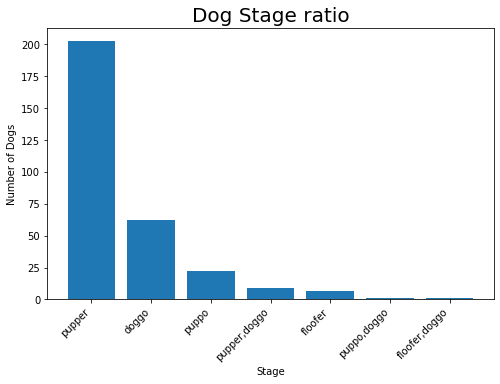

In [95]:
plt.figure(figsize=(8,5))
plt.title('Dog Stage ratio', {'fontsize': 20})
plt.xlabel("Stage")
plt.ylabel("Number of Dogs")
plt.bar(x= df_dog_s['dog_stage'].value_counts().index,
        height= df_dog_s.dog_stage.value_counts().values);
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

## Insights 
- Pupper is the most common stage
- floofer,doggo is the least popular stage 

## Most Used Dog Names

In [96]:
df_merged_data.name.value_counts()[0:10]

Charlie    10
Cooper     10
Oliver     10
Tucker      9
Lucy        9
Penny       9
Winston     8
Sadie       8
Toby        7
Lola        7
Name: name, dtype: int64

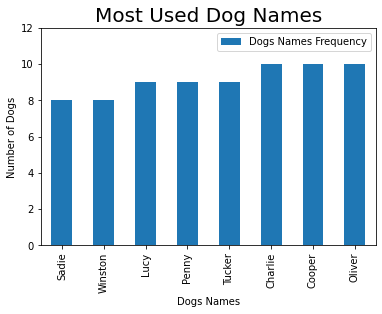

In [97]:
dogs_name = df_merged_data.query('name == name')
dogs_name_grouped = dogs_name.groupby('name').count()[['tweet_id']]
dogs_name_grouped.rename(columns={'tweet_id':'name_count'}, inplace=True)
dogs_name_grouped.query('name_count >= 8').sort_values(by=['name_count']).plot.bar()
plt.ylim(top=12)
plt.title("Most Used Dog Names",{'fontsize': 20})
plt.xlabel("Dogs Names")
plt.ylabel("Number of Dogs")
plt.legend(["Dogs Names Frequency"]);

## Insight
The most common dog names used are `Oliver`, `Cooper` and `Charlie`

## favorite_count vs. retweet_count

Text(0.5, 1.0, 'Distribution of favorite_count')

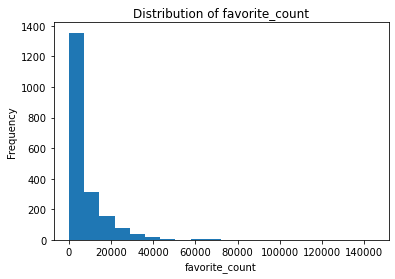

In [98]:
plt.hist(x = df_merged_data.favorite_count, bins = 20)
plt.xlabel('favorite_count')
plt.ylabel('Frequency')
plt.title('Distribution of favorite_count')

Text(0.5, 1.0, 'Distribution of retweet_count')

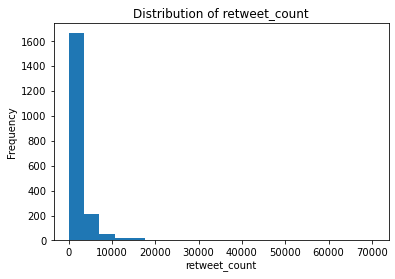

In [99]:
plt.hist(x = df_merged_data.retweet_count, bins = 20)
plt.xlabel('retweet_count')
plt.ylabel('Frequency')
plt.title('Distribution of retweet_count')

Both distribution of `favorite_count` and `retweet_count` are similar. It can be seen that both graphs are positively skewed to the right.

Text(0, 0.5, 'retweet_count')

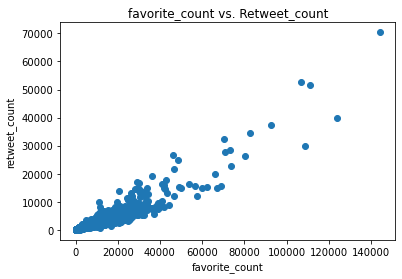

In [100]:
plt.scatter(df_merged_data.favorite_count, df_merged_data.retweet_count);
plt.title('favorite_count vs. Retweet_count')
plt.xlabel('favorite_count')
plt.ylabel('retweet_count')

In [101]:
df_merged_data['favorite_count'].corr(df_merged_data['retweet_count'])

0.9283812212357849

## Insight
It shows very strong positive correlation between favorite count and retweet count with the correlation 0.92